Kaus2010_Rayleigh-Taylor_Instability
======

<table><tr><td><img src='./pic/kaus2010_RT_image0000.png'></td></tr></table>
Initial model setup with buoyancy perturbation.

This notebook models the Rayleigh-Taylor instability outlined in van Kaus *et al.* (2010) for the FSSA algorithm test. 

The system of equations is given by

$$
    \nabla \cdot \left( \eta \nabla \dot\varepsilon \right) - \nabla p = -\rho g \mathbf{\hat z}
$$

$$
    \nabla \cdot \mathbf{v} = 0
$$

**Keywords:** particle swarms, Stokes system, advective diffusive systems

**References**

- Kaus, B.J.P., et al., A stabilization algorithm for geodynamic numerical simulations with a free surface. Phys.
Earth Planet. In. (2010), doi:10.1016/j.pepi.2010.04.007

In [1]:
import underworld as uw
from underworld import function as fn
import underworld.visualisation as vis

from underworld.scaling import units as u
from underworld.scaling import dimensionalise 
from underworld.scaling import non_dimensionalise as nd

import math
import numpy as np
import os

In [2]:
# build reference units
KL_meters   = 500 * u.kilometer
K_viscosity = 1e20  * u.pascal * u.second
K_density   = 3200 * u.kilogram / u.meter**3

# compute dependent scaling units 
#KT_seconds = 5*u.kiloyear
#KM_kilograms = KT_seconds * KL_meters * K_viscosity
KM_kilograms = K_density * KL_meters**3
KT_seconds   = KM_kilograms / ( KL_meters * K_viscosity )
K_substance  = 1. * u.mole
#Kt_degrees   = 1. * u.kelvin

scaling_coefficients = uw.scaling.get_coefficients()
scaling_coefficients["[length]"]      = KL_meters.to_base_units()
#scaling_coefficients["[temperature]"] = Kt_degrees.to_base_units()
scaling_coefficients["[time]"]        = KT_seconds.to_base_units()
scaling_coefficients["[mass]"]        = KM_kilograms.to_base_units()

gravity = nd( 9.81 * u.meter / u.second**2)

ymaxCoord = nd(0.* u.kilometer)
yminCoord = nd(-500* u.kilometer)
xmaxCoord = nd(250* u.kilometer)
xminCoord = nd(-250* u.kilometer)

In [3]:
useFSSA = False
useFreeSlip = False
useFreeSurface = True

time_step  = 4*u.kiloyear
#time_step  = 10*u.kiloyear

DT_str = "%.1f" %(time_step.m)
model_end_step  = int(nd(5.5e3*u.kiloyear)/nd(time_step)+1)
outputEvery = int(np.around(nd(1e2*u.kiloyear)/nd(time_step)))
stokes_inner_tol = 1e-6
stokes_outer_tol = 1e-5


# output path construction
output_path = "Kaus2010RTI_"
if useFreeSurface:
    output_path += "FreeSurface_"+DT_str+"ka"
    
if useFreeSlip:
    output_path += "FreeSlip_"+DT_str+"ka"
    
if not output_path.endswith('/'): output_path += '/'

# search and build, if required, an output path
if uw.mpi.rank==0:
    try:
        if not os.path.exists("./"+output_path):
            os.makedirs("./"+output_path)
    except:
        raise
print(DT_str,model_end_step,outputEvery)

fn_dt = uw.function.misc.constant( nd(time_step) )

4.0 1376 25


In [4]:
# build mesh and mesh variables
resolution       = (64,64)
mesh = uw.mesh.FeMesh_Cartesian( elementType = 'Q1/dQ0', 
                                 elementRes  = resolution, 
                                 minCoord    = [xminCoord,yminCoord], 
                                 maxCoord    = [xmaxCoord,ymaxCoord],
                                 periodic    = [False, False] )

mesh0 = uw.mesh.FeMesh_Cartesian( elementType = 'Q1/dQ0', 
                                 elementRes  = resolution, 
                                 minCoord    = [xminCoord,yminCoord], 
                                 maxCoord    = [xmaxCoord,ymaxCoord],
                                 periodic    = [False, False] )

velocityField   = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=mesh.dim )
pressureField   = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

In [5]:
# Create a swarm.
swarm = uw.swarm.Swarm( mesh=mesh,particleEscape=True)
swarm2 = uw.swarm.Swarm( mesh=mesh, particleEscape=True)

# Create a data variable. It will be used to store the material index of each particle.
materialIndex = swarm.add_variable( dataType="int", count=1 )

# Create a layout object, populate the swarm with particles.
swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
swarm.populate_using_layout( layout=swarmLayout )
pop_control = uw.swarm.PopulationControl(swarm,aggressive=True,splitThreshold=0.15, maxDeletions=2,maxSplits=10,
                                                particlesPerCell=20)

In [6]:
# define these for convience. 
denseIndex = 0
lightIndex = 1

# material perturbation from van Keken et al. 1997
wavelength = nd(xmaxCoord*2)
amplitude  = nd(5*u.kilometer)
offset     = nd(-100.*u.kilometer)
k = 2. * math.pi / wavelength

# Create function to return particle's coordinate
coord = fn.coord()

# Define the material perturbation, a function of the x coordinate (accessed by `coord[0]`).
perturbationFn = offset + amplitude*fn.math.cos( k*coord[0] )

# Setup the conditions list. 
# If z is less than the perturbation, set to lightIndex.
conditions = [ ( perturbationFn > coord[1] , lightIndex ),
               (                      True , denseIndex ) ]

# The swarm is passed as an argument to the evaluation, providing evaluation on each particle.
# Results are written to the materialIndex swarm variable.
materialIndex.data[:] = fn.branching.conditional( conditions ).evaluate(swarm)


interfacePoints = np.zeros((resolution[0]*5,2))
interfacePoints[:,0] = np.linspace(xminCoord, xmaxCoord, resolution[0]*5)
for index in range(len(interfacePoints[:,0])):
    interfacePoints[index,1] = offset + amplitude*math.cos(k*interfacePoints[index,0])
tem = swarm2.add_particles_with_coordinates(interfacePoints)


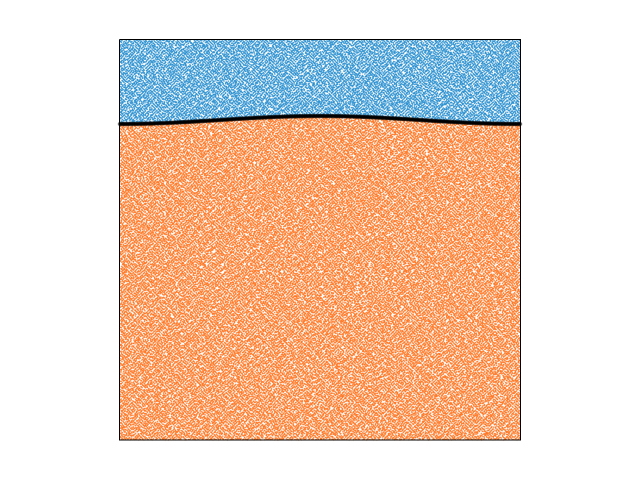

'Kaus2010RTI_FreeSurface_4.0ka/image_0.png'

In [7]:
fig1 = vis.Figure() #title="Material", figsize=(400,400), quality=2, rulers=True)
fig1.Points(swarm2,pointSize=5, colourBar=False)
fig1.Points(swarm, materialIndex, fn_size=2.,discret=True,colourBar = False) 
fig1.VectorArrows(mesh, velocityField) 
fig1.show()
fig1.save_image(output_path+"image_0")


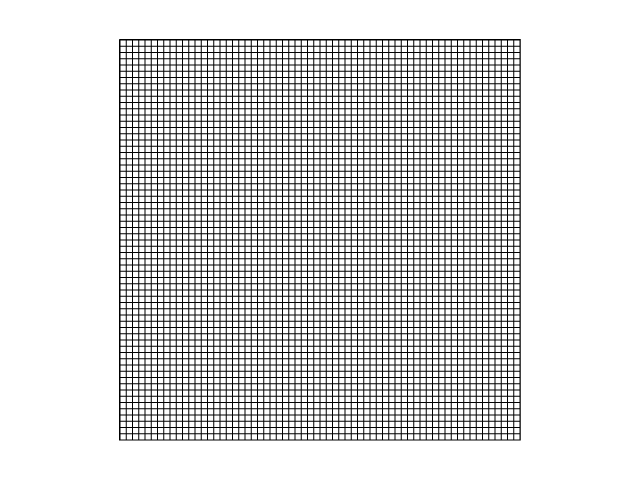

'Kaus2010RTI_FreeSurface_4.0ka/mesh_0.png'

In [8]:
fig2 = vis.Figure() #title="Material", figsize=(400,400), quality=2, rulers=True)
#fig1.Points(swarm, materialIndex, fn_size=2.,discret=True,colourBar = False) 
#fig1.VectorArrows(mesh, velocityField) 
fig2.Mesh(mesh) 
fig2.show()
fig2.save_image(output_path+"mesh_0")

In [9]:
light_density = nd(3200 * u.kilogram / u.meter**3)
dense_density = nd(3300 * u.kilogram / u.meter**3)
light_viscosity = nd(1e20 * u.pascal * u.second)
dense_viscosity = nd(1e21 * u.pascal * u.second)


# Set a density of '0.' for light material, '1.' for dense material.
densityMap   = { lightIndex:light_density, denseIndex:dense_density }
densityFn    = fn.branching.map( fn_key = materialIndex, mapping = densityMap )

# Set a viscosity value of '1.' for both materials.
viscosityMap = { lightIndex:light_viscosity, denseIndex:dense_viscosity }
fn_viscosity  = fn.branching.map( fn_key = materialIndex, mapping = viscosityMap )

# Define a vertical unit vector using a python tuple.
z_hat = ( 0.0, -1.0 )

# Create buoyancy force vector
buoyancyFn = densityFn*z_hat*gravity

In [10]:
# Construct node sets using the mesh specialSets
iWalls = mesh.specialSets["Left_VertexSet"]   + mesh.specialSets["Right_VertexSet"]
jWalls = mesh.specialSets["Bottom_VertexSet"] + mesh.specialSets["Top_VertexSet"]
botWalls = mesh.specialSets["Bottom_VertexSet"]
allWalls = iWalls + jWalls

if useFreeSurface:
    # free slip sides, no slip bottom, open top
    stokesBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                             indexSetsPerDof = (iWalls+botWalls, botWalls) )

# if useFreeSlip:
#     # free slip sides, no slip bottom, free lip top
#     stokesBC = uw.conditions.DirichletCondition( variable      = velocityField, 
#                                              indexSetsPerDof = (iWalls+botWalls,jWalls) )

In [11]:
# define an update function
fn_fssa = None
proj_buoy = True # for initial debug
if useFSSA == True:
    print("use FSSA")
    fn_fssa = buoyancyFn * DT *  theta
    
if proj_buoy == True:
    pbuoy = mesh.add_variable(nodeDofCount=mesh.dim)
    projB = uw.utils.MeshVariable_Projection(pbuoy, fn=buoyancyFn)

stokes = uw.systems.Stokes( velocityField = velocityField, 
                            pressureField = pressureField,
                            voronoi_swarm = swarm,
                            conditions    = stokesBC,
                            fn_viscosity  = fn_viscosity, 
                            fn_bodyforce  = buoyancyFn)
                           # _fn_fssa      = fn_fssa)
                           # _fn_fssa      = fn_fssa)

solver = uw.systems.Solver( stokes )

# Optional solver settings
if(uw.mpi.size==1):
    solver.set_inner_method("lu")
solver.set_inner_rtol(stokes_inner_tol) 
solver.set_outer_rtol(stokes_outer_tol) 

# Create a system to advect the swarm
advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )
advector2 = uw.systems.SwarmAdvector( swarm=swarm2, velocityField=velocityField, order=2 )

In [12]:
# projB.solve()
# fig = vis.Figure() #title="Material", figsize=(400,400), quality=2, rulers=True)
# # fig.Sur(swarm, materialIndex, fn_size=2.,discret=True,colourBar = False) 
# fig.append( vis.objects.Surface(mesh, buoyancyFn[1], colours="blue white red") )

# fig.VectorArrows(mesh, buoyancyFn) 
# fig.show()
# # fig1.save_image(output_path+"image_0")

In [13]:
from scipy.interpolate import interp1d
import underworld as uw
from mpi4py import MPI as _MPI

comm = _MPI.COMM_WORLD
rank = comm.rank
size = comm.size

class FreeSurfaceProcessor(object):
    """FreeSurfaceProcessor"""

    def __init__(self):
        """Create a Freesurface processor


        """
        # Create the tools
        self.TField = mesh0.add_variable(nodeDofCount=1)
        self.TField.data[:, 0] = mesh0.data[:, 1]

        self.top = mesh0.specialSets["Top_VertexSet"]
        self.bottom = mesh0.specialSets["Bottom_VertexSet"]
        
        # Create boundary condition
        self._conditions = uw.conditions.DirichletCondition(
            variable=self.TField,
            indexSetsPerDof=(self.top + self.bottom,))

        # Create Eq System
        self._system = uw.systems.SteadyStateHeat(
            temperatureField=self.TField,
            fn_diffusivity=1.0,
            conditions=self._conditions)

        self._solver = uw.systems.Solver(self._system)

    def _solve_sle(self):
        self._solver.solve()

    def _advect_surface(self, dt):

        if self.top:
            # Extract top surface
            x =  mesh.data[self.top.data, 0]
            y =  mesh.data[self.top.data, 1]

            # Extract velocities from top
            vx = velocityField.data[self.top.data, 0]
            vy = velocityField.data[self.top.data, 1]

            # Advect top surface
            x2 = x + vx * nd(dt)
            y2 = y + vy * nd(dt)

            # Spline top surface
            f = interp1d(x2, y2, kind='cubic', fill_value='extrapolate')

            self.TField.data[self.top.data, 0] = f(x)
        comm.Barrier()
        self.TField.syncronise()

    def _update_mesh(self):

        with  mesh.deform_mesh():
            # Last dimension is the vertical dimension
             mesh.data[:, -1] = self.TField.data[:, 0]

    def solve(self, dtime):
        """ Advect free surface through dt and update the mesh """
        # First we advect the surface
        self._advect_surface(dtime)
        # Then we solve the system of linear equation
        self._solve_sle()
        # Finally we update the mesh
        self._update_mesh()

In [14]:
# Initialise time and timestep.
time = 0.
step = 0

# parameters for output
timeVal     = []
vrmsVal     = []

# Save mesh and retain file handle for future xdmf creation
meshFileHandle = mesh.save(output_path+"Mesh.h5")


def update():   
    #dt = advector.get_max_dt() # retrieve the maximum possible timestep from the advection system.
    dt = fn_dt.value 
    advector.integrate(dt, update_owners=False)  #?update_owners=True
    advector2.integrate(dt,update_owners=False)
        
    #pop_control.repopulate()
    
    if useFreeSurface:
        freesuface =  FreeSurfaceProcessor()
        freesuface.solve(dt)

        
    swarm.update_particle_owners()
    swarm2.update_particle_owners()
    pop_control.repopulate()
    
    return time+dt, step+1, dt

In [15]:
while step < model_end_step:
    # Get solution
    solver.solve()
    
    # Calculate the RMS velocity.
    vrms = stokes.velocity_rms()

    # Record values into arrays
    if(uw.mpi.rank==0):
        vrmsVal.append(dimensionalise(vrms,u.meter/u.year).m)
        timeVal.append(dimensionalise(time, u.kiloyear).m)
     
    time, step, dt = update()
    if(uw.mpi.rank==0):
        string = "{:4d}, {:.3e},{:.3e},{:.3e}".format(step,dimensionalise(dt, u.kiloyear),dimensionalise(time, u.kiloyear),dimensionalise(vrms,u.meter/u.year)) 
        print(string)
                                                   
    # Output to disk
    if step%outputEvery == 0:
        #if(uw.mpi.rank==0):
        #    print('step = {0:6d}; time = {1:.3e}; v_rms = {2:.3e}'.format(step,time,vrms))

        filename = output_path+"/velocityField."+str(step).zfill(4)
        vFH      = velocityField.save(filename+".h5")
        velocityField.xdmf( filename, vFH, "velocity", meshFileHandle, "Mesh", time )
        
        filename = output_path+"/pressureField."+str(step).zfill(4)
        pFH      = pressureField.save(filename+".h5")
        pressureField.xdmf(filename, pFH, "pressure", meshFileHandle, "Mesh", time )
        
        swarm2.save(output_path+"surfaceSwarm"+ str(step).zfill(4)+".h5")
        
        outputFilename = output_path+"image"+str(step).zfill(4)
        fig1.save_image(outputFilename)

        outputFilename = output_path+"mesh"+str(step).zfill(4)
        fig2.save_image(outputFilename)

        
    # We are finished with current timestep, update.
    #updateMesh()

fname_save = output_path+"data_time_vrms.txt"
np.savetxt(fname_save, np.column_stack((timeVal ,vrmsVal)),fmt='%1.3e %1.3e')

   1, 4.000e+00 kiloyear,4.000e+00 kiloyear,7.951e-03 meter / year
   2, 4.000e+00 kiloyear,8.000e+00 kiloyear,4.955e-03 meter / year
   3, 4.000e+00 kiloyear,1.200e+01 kiloyear,3.416e-03 meter / year
   4, 4.000e+00 kiloyear,1.600e+01 kiloyear,2.614e-03 meter / year
   5, 4.000e+00 kiloyear,2.000e+01 kiloyear,2.270e-03 meter / year
   6, 4.000e+00 kiloyear,2.400e+01 kiloyear,2.067e-03 meter / year
   7, 4.000e+00 kiloyear,2.800e+01 kiloyear,1.988e-03 meter / year
   8, 4.000e+00 kiloyear,3.200e+01 kiloyear,1.941e-03 meter / year
   9, 4.000e+00 kiloyear,3.600e+01 kiloyear,1.927e-03 meter / year
  10, 4.000e+00 kiloyear,4.000e+01 kiloyear,1.916e-03 meter / year
  11, 4.000e+00 kiloyear,4.400e+01 kiloyear,1.911e-03 meter / year
  12, 4.000e+00 kiloyear,4.800e+01 kiloyear,1.906e-03 meter / year
  13, 4.000e+00 kiloyear,5.200e+01 kiloyear,1.905e-03 meter / year
  14, 4.000e+00 kiloyear,5.600e+01 kiloyear,1.905e-03 meter / year
  15, 4.000e+00 kiloyear,6.000e+01 kiloyear,1.915e-03 meter / 

 124, 4.000e+00 kiloyear,4.960e+02 kiloyear,2.600e-03 meter / year
 125, 4.000e+00 kiloyear,5.000e+02 kiloyear,2.603e-03 meter / year
 126, 4.000e+00 kiloyear,5.040e+02 kiloyear,2.603e-03 meter / year
 127, 4.000e+00 kiloyear,5.080e+02 kiloyear,2.608e-03 meter / year
 128, 4.000e+00 kiloyear,5.120e+02 kiloyear,2.619e-03 meter / year
 129, 4.000e+00 kiloyear,5.160e+02 kiloyear,2.618e-03 meter / year
 130, 4.000e+00 kiloyear,5.200e+02 kiloyear,2.619e-03 meter / year
 131, 4.000e+00 kiloyear,5.240e+02 kiloyear,2.654e-03 meter / year
 132, 4.000e+00 kiloyear,5.280e+02 kiloyear,2.660e-03 meter / year
 133, 4.000e+00 kiloyear,5.320e+02 kiloyear,2.665e-03 meter / year
 134, 4.000e+00 kiloyear,5.360e+02 kiloyear,2.669e-03 meter / year
 135, 4.000e+00 kiloyear,5.400e+02 kiloyear,2.676e-03 meter / year
 136, 4.000e+00 kiloyear,5.440e+02 kiloyear,2.677e-03 meter / year
 137, 4.000e+00 kiloyear,5.480e+02 kiloyear,2.678e-03 meter / year
 138, 4.000e+00 kiloyear,5.520e+02 kiloyear,2.680e-03 meter / 

 247, 4.000e+00 kiloyear,9.880e+02 kiloyear,3.662e-03 meter / year
 248, 4.000e+00 kiloyear,9.920e+02 kiloyear,3.729e-03 meter / year
 249, 4.000e+00 kiloyear,9.960e+02 kiloyear,3.750e-03 meter / year
 250, 4.000e+00 kiloyear,1.000e+03 kiloyear,3.751e-03 meter / year
 251, 4.000e+00 kiloyear,1.004e+03 kiloyear,3.759e-03 meter / year
 252, 4.000e+00 kiloyear,1.008e+03 kiloyear,3.767e-03 meter / year
 253, 4.000e+00 kiloyear,1.012e+03 kiloyear,3.786e-03 meter / year
 254, 4.000e+00 kiloyear,1.016e+03 kiloyear,3.783e-03 meter / year
 255, 4.000e+00 kiloyear,1.020e+03 kiloyear,3.798e-03 meter / year
 256, 4.000e+00 kiloyear,1.024e+03 kiloyear,3.780e-03 meter / year
 257, 4.000e+00 kiloyear,1.028e+03 kiloyear,3.795e-03 meter / year
 258, 4.000e+00 kiloyear,1.032e+03 kiloyear,3.797e-03 meter / year
 259, 4.000e+00 kiloyear,1.036e+03 kiloyear,3.815e-03 meter / year
 260, 4.000e+00 kiloyear,1.040e+03 kiloyear,3.811e-03 meter / year
 261, 4.000e+00 kiloyear,1.044e+03 kiloyear,3.826e-03 meter / 

 370, 4.000e+00 kiloyear,1.480e+03 kiloyear,5.329e-03 meter / year
 371, 4.000e+00 kiloyear,1.484e+03 kiloyear,5.343e-03 meter / year
 372, 4.000e+00 kiloyear,1.488e+03 kiloyear,5.380e-03 meter / year
 373, 4.000e+00 kiloyear,1.492e+03 kiloyear,5.374e-03 meter / year
 374, 4.000e+00 kiloyear,1.496e+03 kiloyear,5.381e-03 meter / year
 375, 4.000e+00 kiloyear,1.500e+03 kiloyear,5.393e-03 meter / year
 376, 4.000e+00 kiloyear,1.504e+03 kiloyear,5.394e-03 meter / year
 377, 4.000e+00 kiloyear,1.508e+03 kiloyear,5.409e-03 meter / year
 378, 4.000e+00 kiloyear,1.512e+03 kiloyear,5.426e-03 meter / year
 379, 4.000e+00 kiloyear,1.516e+03 kiloyear,5.469e-03 meter / year
 380, 4.000e+00 kiloyear,1.520e+03 kiloyear,5.479e-03 meter / year
 381, 4.000e+00 kiloyear,1.524e+03 kiloyear,5.501e-03 meter / year
 382, 4.000e+00 kiloyear,1.528e+03 kiloyear,5.499e-03 meter / year
 383, 4.000e+00 kiloyear,1.532e+03 kiloyear,5.504e-03 meter / year
 384, 4.000e+00 kiloyear,1.536e+03 kiloyear,5.538e-03 meter / 

 493, 4.000e+00 kiloyear,1.972e+03 kiloyear,7.579e-03 meter / year
 494, 4.000e+00 kiloyear,1.976e+03 kiloyear,7.643e-03 meter / year
 495, 4.000e+00 kiloyear,1.980e+03 kiloyear,7.651e-03 meter / year
 496, 4.000e+00 kiloyear,1.984e+03 kiloyear,7.669e-03 meter / year
 497, 4.000e+00 kiloyear,1.988e+03 kiloyear,7.685e-03 meter / year
 498, 4.000e+00 kiloyear,1.992e+03 kiloyear,7.699e-03 meter / year
 499, 4.000e+00 kiloyear,1.996e+03 kiloyear,7.724e-03 meter / year
 500, 4.000e+00 kiloyear,2.000e+03 kiloyear,7.774e-03 meter / year
 501, 4.000e+00 kiloyear,2.004e+03 kiloyear,7.785e-03 meter / year
 502, 4.000e+00 kiloyear,2.008e+03 kiloyear,7.800e-03 meter / year
 503, 4.000e+00 kiloyear,2.012e+03 kiloyear,7.834e-03 meter / year
 504, 4.000e+00 kiloyear,2.016e+03 kiloyear,7.843e-03 meter / year
 505, 4.000e+00 kiloyear,2.020e+03 kiloyear,7.871e-03 meter / year
 506, 4.000e+00 kiloyear,2.024e+03 kiloyear,7.901e-03 meter / year
 507, 4.000e+00 kiloyear,2.028e+03 kiloyear,7.914e-03 meter / 

 616, 4.000e+00 kiloyear,2.464e+03 kiloyear,1.093e-02 meter / year
 617, 4.000e+00 kiloyear,2.468e+03 kiloyear,1.100e-02 meter / year
 618, 4.000e+00 kiloyear,2.472e+03 kiloyear,1.103e-02 meter / year
 619, 4.000e+00 kiloyear,2.476e+03 kiloyear,1.105e-02 meter / year
 620, 4.000e+00 kiloyear,2.480e+03 kiloyear,1.109e-02 meter / year
 621, 4.000e+00 kiloyear,2.484e+03 kiloyear,1.113e-02 meter / year
 622, 4.000e+00 kiloyear,2.488e+03 kiloyear,1.114e-02 meter / year
 623, 4.000e+00 kiloyear,2.492e+03 kiloyear,1.122e-02 meter / year
 624, 4.000e+00 kiloyear,2.496e+03 kiloyear,1.122e-02 meter / year
 625, 4.000e+00 kiloyear,2.500e+03 kiloyear,1.126e-02 meter / year
 626, 4.000e+00 kiloyear,2.504e+03 kiloyear,1.128e-02 meter / year
 627, 4.000e+00 kiloyear,2.508e+03 kiloyear,1.131e-02 meter / year
 628, 4.000e+00 kiloyear,2.512e+03 kiloyear,1.133e-02 meter / year
 629, 4.000e+00 kiloyear,2.516e+03 kiloyear,1.139e-02 meter / year
 630, 4.000e+00 kiloyear,2.520e+03 kiloyear,1.143e-02 meter / 

 739, 4.000e+00 kiloyear,2.956e+03 kiloyear,1.602e-02 meter / year
 740, 4.000e+00 kiloyear,2.960e+03 kiloyear,1.607e-02 meter / year
 741, 4.000e+00 kiloyear,2.964e+03 kiloyear,1.611e-02 meter / year
 742, 4.000e+00 kiloyear,2.968e+03 kiloyear,1.618e-02 meter / year
 743, 4.000e+00 kiloyear,2.972e+03 kiloyear,1.623e-02 meter / year
 744, 4.000e+00 kiloyear,2.976e+03 kiloyear,1.629e-02 meter / year
 745, 4.000e+00 kiloyear,2.980e+03 kiloyear,1.634e-02 meter / year
 746, 4.000e+00 kiloyear,2.984e+03 kiloyear,1.639e-02 meter / year
 747, 4.000e+00 kiloyear,2.988e+03 kiloyear,1.644e-02 meter / year
 748, 4.000e+00 kiloyear,2.992e+03 kiloyear,1.652e-02 meter / year
 749, 4.000e+00 kiloyear,2.996e+03 kiloyear,1.658e-02 meter / year
 750, 4.000e+00 kiloyear,3.000e+03 kiloyear,1.661e-02 meter / year
 751, 4.000e+00 kiloyear,3.004e+03 kiloyear,1.667e-02 meter / year
 752, 4.000e+00 kiloyear,3.008e+03 kiloyear,1.669e-02 meter / year
 753, 4.000e+00 kiloyear,3.012e+03 kiloyear,1.677e-02 meter / 

 862, 4.000e+00 kiloyear,3.448e+03 kiloyear,2.413e-02 meter / year
 863, 4.000e+00 kiloyear,3.452e+03 kiloyear,2.417e-02 meter / year
 864, 4.000e+00 kiloyear,3.456e+03 kiloyear,2.422e-02 meter / year
 865, 4.000e+00 kiloyear,3.460e+03 kiloyear,2.432e-02 meter / year
 866, 4.000e+00 kiloyear,3.464e+03 kiloyear,2.441e-02 meter / year
 867, 4.000e+00 kiloyear,3.468e+03 kiloyear,2.447e-02 meter / year
 868, 4.000e+00 kiloyear,3.472e+03 kiloyear,2.455e-02 meter / year
 869, 4.000e+00 kiloyear,3.476e+03 kiloyear,2.470e-02 meter / year
 870, 4.000e+00 kiloyear,3.480e+03 kiloyear,2.477e-02 meter / year
 871, 4.000e+00 kiloyear,3.484e+03 kiloyear,2.485e-02 meter / year
 872, 4.000e+00 kiloyear,3.488e+03 kiloyear,2.492e-02 meter / year
 873, 4.000e+00 kiloyear,3.492e+03 kiloyear,2.499e-02 meter / year
 874, 4.000e+00 kiloyear,3.496e+03 kiloyear,2.513e-02 meter / year
 875, 4.000e+00 kiloyear,3.500e+03 kiloyear,2.520e-02 meter / year
 876, 4.000e+00 kiloyear,3.504e+03 kiloyear,2.529e-02 meter / 

 985, 4.000e+00 kiloyear,3.940e+03 kiloyear,3.732e-02 meter / year
 986, 4.000e+00 kiloyear,3.944e+03 kiloyear,3.751e-02 meter / year
 987, 4.000e+00 kiloyear,3.948e+03 kiloyear,3.763e-02 meter / year
 988, 4.000e+00 kiloyear,3.952e+03 kiloyear,3.782e-02 meter / year
 989, 4.000e+00 kiloyear,3.956e+03 kiloyear,3.790e-02 meter / year
 990, 4.000e+00 kiloyear,3.960e+03 kiloyear,3.810e-02 meter / year
 991, 4.000e+00 kiloyear,3.964e+03 kiloyear,3.817e-02 meter / year
 992, 4.000e+00 kiloyear,3.968e+03 kiloyear,3.837e-02 meter / year
 993, 4.000e+00 kiloyear,3.972e+03 kiloyear,3.848e-02 meter / year
 994, 4.000e+00 kiloyear,3.976e+03 kiloyear,3.858e-02 meter / year
 995, 4.000e+00 kiloyear,3.980e+03 kiloyear,3.873e-02 meter / year
 996, 4.000e+00 kiloyear,3.984e+03 kiloyear,3.888e-02 meter / year
 997, 4.000e+00 kiloyear,3.988e+03 kiloyear,3.902e-02 meter / year
 998, 4.000e+00 kiloyear,3.992e+03 kiloyear,3.916e-02 meter / year
 999, 4.000e+00 kiloyear,3.996e+03 kiloyear,3.933e-02 meter / 

1108, 4.000e+00 kiloyear,4.432e+03 kiloyear,6.035e-02 meter / year
1109, 4.000e+00 kiloyear,4.436e+03 kiloyear,6.060e-02 meter / year
1110, 4.000e+00 kiloyear,4.440e+03 kiloyear,6.086e-02 meter / year
1111, 4.000e+00 kiloyear,4.444e+03 kiloyear,6.111e-02 meter / year
1112, 4.000e+00 kiloyear,4.448e+03 kiloyear,6.141e-02 meter / year
1113, 4.000e+00 kiloyear,4.452e+03 kiloyear,6.164e-02 meter / year
1114, 4.000e+00 kiloyear,4.456e+03 kiloyear,6.192e-02 meter / year
1115, 4.000e+00 kiloyear,4.460e+03 kiloyear,6.214e-02 meter / year
1116, 4.000e+00 kiloyear,4.464e+03 kiloyear,6.235e-02 meter / year
1117, 4.000e+00 kiloyear,4.468e+03 kiloyear,6.263e-02 meter / year
1118, 4.000e+00 kiloyear,4.472e+03 kiloyear,6.279e-02 meter / year
1119, 4.000e+00 kiloyear,4.476e+03 kiloyear,6.312e-02 meter / year
1120, 4.000e+00 kiloyear,4.480e+03 kiloyear,6.331e-02 meter / year
1121, 4.000e+00 kiloyear,4.484e+03 kiloyear,6.364e-02 meter / year
1122, 4.000e+00 kiloyear,4.488e+03 kiloyear,6.381e-02 meter / 

1231, 4.000e+00 kiloyear,4.924e+03 kiloyear,9.851e-02 meter / year
1232, 4.000e+00 kiloyear,4.928e+03 kiloyear,9.879e-02 meter / year
1233, 4.000e+00 kiloyear,4.932e+03 kiloyear,9.922e-02 meter / year
1234, 4.000e+00 kiloyear,4.936e+03 kiloyear,9.953e-02 meter / year
1235, 4.000e+00 kiloyear,4.940e+03 kiloyear,9.993e-02 meter / year
1236, 4.000e+00 kiloyear,4.944e+03 kiloyear,1.004e-01 meter / year
1237, 4.000e+00 kiloyear,4.948e+03 kiloyear,1.005e-01 meter / year
1238, 4.000e+00 kiloyear,4.952e+03 kiloyear,1.010e-01 meter / year
1239, 4.000e+00 kiloyear,4.956e+03 kiloyear,1.012e-01 meter / year
1240, 4.000e+00 kiloyear,4.960e+03 kiloyear,1.015e-01 meter / year
1241, 4.000e+00 kiloyear,4.964e+03 kiloyear,1.020e-01 meter / year
1242, 4.000e+00 kiloyear,4.968e+03 kiloyear,1.023e-01 meter / year
1243, 4.000e+00 kiloyear,4.972e+03 kiloyear,1.026e-01 meter / year
1244, 4.000e+00 kiloyear,4.976e+03 kiloyear,1.030e-01 meter / year
1245, 4.000e+00 kiloyear,4.980e+03 kiloyear,1.033e-01 meter / 

1354, 4.000e+00 kiloyear,5.416e+03 kiloyear,1.193e-01 meter / year
1355, 4.000e+00 kiloyear,5.420e+03 kiloyear,1.192e-01 meter / year
1356, 4.000e+00 kiloyear,5.424e+03 kiloyear,1.190e-01 meter / year
1357, 4.000e+00 kiloyear,5.428e+03 kiloyear,1.187e-01 meter / year
1358, 4.000e+00 kiloyear,5.432e+03 kiloyear,1.185e-01 meter / year
1359, 4.000e+00 kiloyear,5.436e+03 kiloyear,1.181e-01 meter / year
1360, 4.000e+00 kiloyear,5.440e+03 kiloyear,1.179e-01 meter / year
1361, 4.000e+00 kiloyear,5.444e+03 kiloyear,1.177e-01 meter / year
1362, 4.000e+00 kiloyear,5.448e+03 kiloyear,1.174e-01 meter / year
1363, 4.000e+00 kiloyear,5.452e+03 kiloyear,1.172e-01 meter / year
1364, 4.000e+00 kiloyear,5.456e+03 kiloyear,1.168e-01 meter / year
1365, 4.000e+00 kiloyear,5.460e+03 kiloyear,1.166e-01 meter / year
1366, 4.000e+00 kiloyear,5.464e+03 kiloyear,1.164e-01 meter / year
1367, 4.000e+00 kiloyear,5.468e+03 kiloyear,1.160e-01 meter / year
1368, 4.000e+00 kiloyear,5.472e+03 kiloyear,1.157e-01 meter / 

In [16]:
0.3e3/5

60.0